<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/GAN_MNIST_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [15]:
torch.__version__

'1.12.1+cu113'

In [16]:
#this is a visualization function
def show_images(input, channel=1, size=(28,28), sizegrid=6):
  #The imput is a vector of (samples, size), that is a comprossed nxn image (784 in this example)
  data = input.detach().cpu().view(-1, channel, *size) # move from (samples,nxn) vector to a (samples, 1, n, n) and move it to a CPU
  grid = make_grid(tensor=data[:sizegrid**2], nrow=sizegrid, padding=False).permute(1,2,0) # create a sizegrid x sizegrid grid ready for being plot (permute)
 
#  print(data.shape, grid.shape)
  plt.imshow(grid)
  plt.show()



In [17]:



# HyperParameters
EPOCHS = 750
INFO_STEP = 4800
ZDIM = 128
LR = 1e-5
BATCHSIZE = 125
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATALOADER = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=BATCHSIZE)


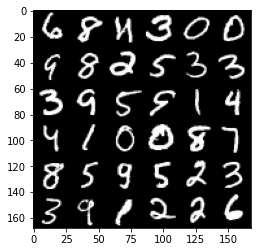

In [18]:
x, y = next(iter(DATALOADER))
show_images(x.view(-1,784))

In [19]:
#Noise generator
def noiseGenerator(nVectors, zDim):
  return torch.randn(nVectors, zDim).to(DEVICE)


In [20]:
from torch.nn.modules.activation import ReLU
#defining two models, Generator and Discriinator

def generatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True) #optimize memory because makes the operation directly
  )

class generatorClass(nn.Module):
  def __init__(self, zDim, hiddenDim, outputDim):
    super().__init__()
    self.gen = nn.Sequential(
        generatorBlock(zDim, hiddenDim),
        generatorBlock(hiddenDim, 2*hiddenDim),
        generatorBlock(2*hiddenDim, 4*hiddenDim),
        generatorBlock(4*hiddenDim, 8*hiddenDim),
        nn.Linear(8*hiddenDim, outputDim),
        nn.Sigmoid(),
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)
  
  def forward(self, noise):
    return self.gen(noise)


def discriminatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.2, inplace=True) #The size of the slope is 0.2
  )

class discriminatorClass(nn.Module):
  def __init__(self,inputDim):
    super().__init__()
    self.disc = nn.Sequential(
        discriminatorBlock(inputDim, int(inputDim/2)),
        discriminatorBlock(int(inputDim/2), int(inputDim/4)),
        discriminatorBlock(int(inputDim/4), int(inputDim/8)),
        nn.Linear(int(inputDim/8),1)
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)


  def forward(self, image):
    return self.disc(image)


In [21]:
#defining a GAN
class ganClass(nn.Module):
  def __init__(self, zDim, hiddenGenDim, inputDiscDim):
    super().__init__()
    self.generator = generatorClass(zDim, hiddenGenDim, inputDiscDim)
    self.discriminator = discriminatorClass(inputDiscDim)
    self.lossFunction = nn.BCEWithLogitsLoss()

  def forward(self, noise):
    return self.discriminator(self.generator(noise))

  def lossGenCalculation(self, number, zDim):
    preds = self.discriminator(self.generator(noiseGenerator(number, zDim)))
    return self.lossFunction(preds, torch.ones_like(preds).to(DEVICE))
  
  def lossDiscCalculation(self, number, zDim, real):
    discFake = self.discriminator(self.generator(noiseGenerator(number, zDim)).detach())
    discFakeLoss = self.lossFunction(discFake, torch.zeros_like(discFake).to(DEVICE))
    discReal = self.discriminator(real)
    discRealLoss = self.lossFunction(discReal, torch.ones_like(discReal).to(DEVICE))
    return (discFakeLoss+discRealLoss)/2

  def fit(self, zDim, dataloader=DATALOADER, epochs = EPOCHS):
    
    #Setup main parameters
    currentStep = 0
    currentBatchSize = 0
    meanGeneratorLoss = 0
    mGL = []
    mDL = []
    meanDiscrtiminatorLoss = 0

    
    for epoch in tqdm(range(epochs)):
      for real, _ in dataloader:
        #trainning discriminator
        real=real.to(DEVICE)
        self.discriminator.optimizer.zero_grad()
        currentBatchSize = len(real)
        real = real.view(currentBatchSize, -1) #resizes to 128 x xx for example
        discLoss = self.lossDiscCalculation(currentBatchSize, zDim, real)
        discLoss.backward(retain_graph=True)
        self.discriminator.optimizer.step()


        #trainning generator
        self.generator.optimizer.zero_grad()
        genLoss = self.lossGenCalculation(currentBatchSize,zDim)
        genLoss.backward(retain_graph=True)
        self.generator.optimizer.step()

        meanDiscrtiminatorLoss+= discLoss.item() / INFO_STEP
        meanGeneratorLoss += genLoss.item() / INFO_STEP
        mDL.append(discLoss.item())
        mGL.append(genLoss.item())

        if (currentStep+1) % INFO_STEP == 0 or currentStep == 10:
          fake = self.generator(noiseGenerator(currentBatchSize, zDim))
          show_images(fake)
          print(f'{epoch}, step: {currentStep} from {epochs*len(dataloader)}, MeanDiscLoss: {meanDiscrtiminatorLoss}, GenDiscLoss: {meanGeneratorLoss}')
          plt.plot(mDL, label="DiscLoss")
          plt.plot(mGL, label = "GenLoss")
          plt.legend()
          plt.show()
          meanGeneratorLoss, meanDiscrtiminatorLoss = 0,0
        currentStep+= 1  

    return(mDL, mGL)



  0%|          | 0/750 [00:00<?, ?it/s]

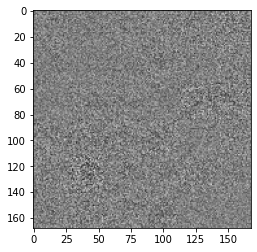

0, step: 10 from 360000, MeanDiscLoss: 0.0015740910917520527, GenDiscLoss: 0.001593531457086404


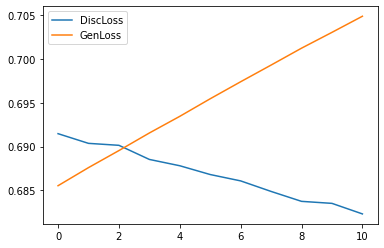

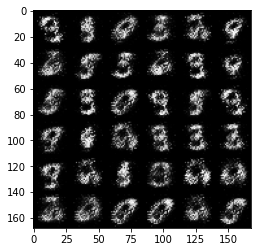

9, step: 4799 from 360000, MeanDiscLoss: 0.28409603800779903, GenDiscLoss: 1.5827331155662743


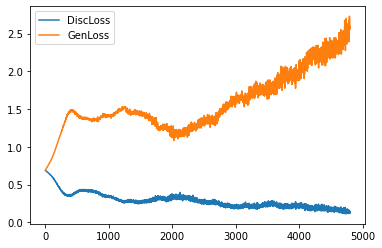

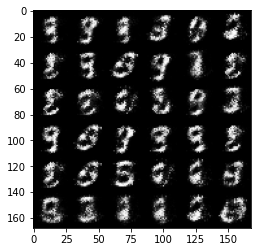

19, step: 9599 from 360000, MeanDiscLoss: 0.11589768996617456, GenDiscLoss: 3.0538618982334946


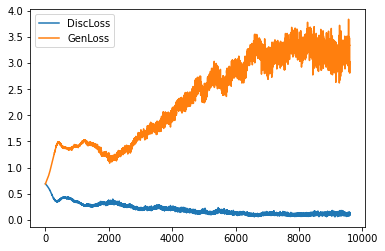

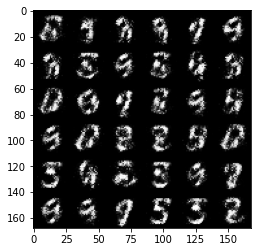

29, step: 14399 from 360000, MeanDiscLoss: 0.12990074958497008, GenDiscLoss: 3.248497525900605


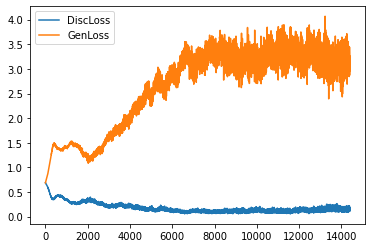

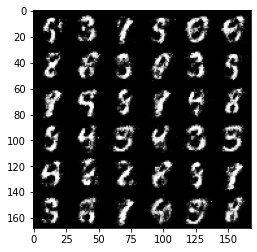

39, step: 19199 from 360000, MeanDiscLoss: 0.17584601435655106, GenDiscLoss: 3.0040433674554023


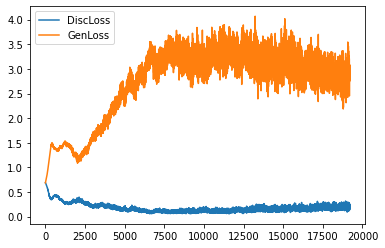

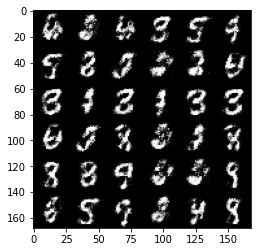

49, step: 23999 from 360000, MeanDiscLoss: 0.20806564189804042, GenDiscLoss: 2.7388154420753303


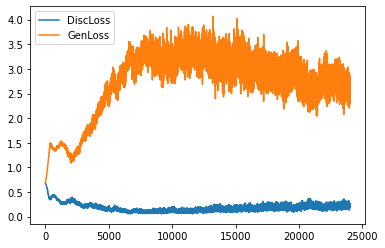

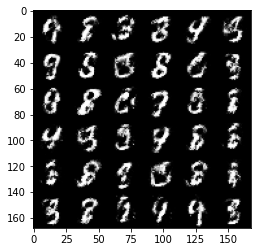

59, step: 28799 from 360000, MeanDiscLoss: 0.24853460303818134, GenDiscLoss: 2.4221587403118696


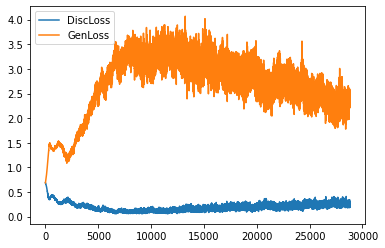

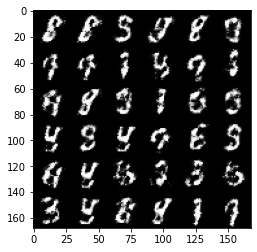

69, step: 33599 from 360000, MeanDiscLoss: 0.2726846705346054, GenDiscLoss: 2.255741151223579


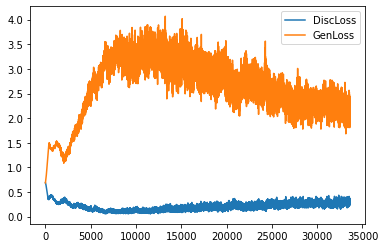

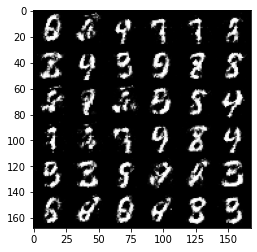

79, step: 38399 from 360000, MeanDiscLoss: 0.29562369007306827, GenDiscLoss: 2.114500009020165


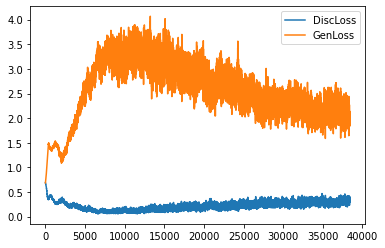

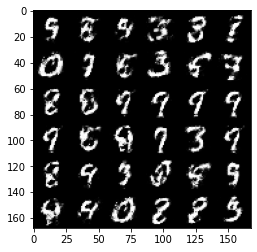

89, step: 43199 from 360000, MeanDiscLoss: 0.3275263858058798, GenDiscLoss: 1.9482652020951103


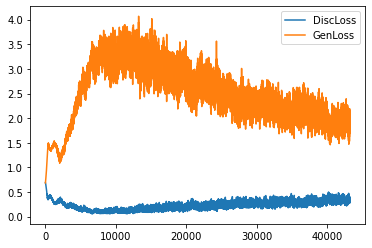

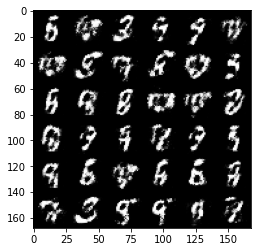

99, step: 47999 from 360000, MeanDiscLoss: 0.34039534451439835, GenDiscLoss: 1.8863995522509052


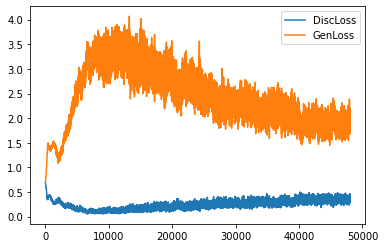

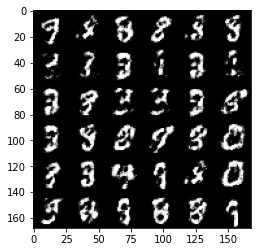

109, step: 52799 from 360000, MeanDiscLoss: 0.3770156407418354, GenDiscLoss: 1.718438360467554


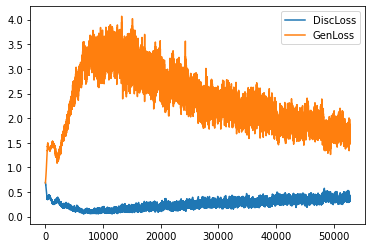

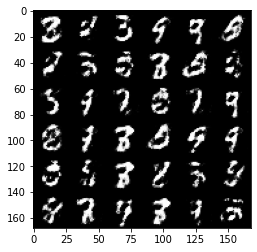

119, step: 57599 from 360000, MeanDiscLoss: 0.3827390184936419, GenDiscLoss: 1.678719979872306


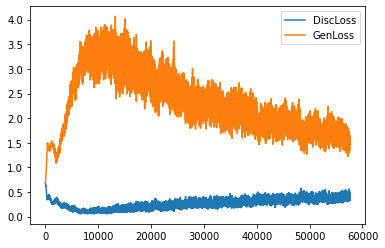

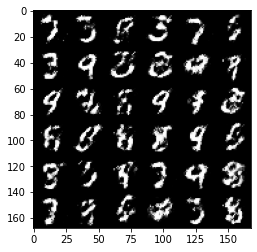

129, step: 62399 from 360000, MeanDiscLoss: 0.42944469215348424, GenDiscLoss: 1.4907669749359247


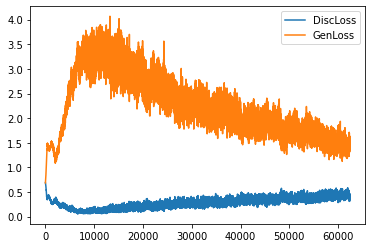

In [ ]:
gan = ganClass(zDim=ZDIM,hiddenGenDim=128,inputDiscDim=784).to(DEVICE)
mDL, mGL = gan.fit(zDim=ZDIM)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(gan,'/content/drive/MyDrive/gan_4_0.pt')